In [1]:
import numpy as np
from matplotlib import pyplot as plt
import types
import scipy.integrate as sp

In [2]:
#CI :
x_m , x_M = -10 , 10  #limites du domaine d'intégration
psi_x_m , psi_x_M = 0 , 0  #valeurs de la fonction d'onde aux limites

#potentiel
V_0 = 5
a = 2
def V (x):
    #square well
    return -V_0/2*(1-np.sign(np.abs(x)-a))

b = 2
def V_2 (x):
    #quadratic well
    return V_0/2*((x/b)**2-1)*(1-np.sign(np.abs(x)-b))

def Lennard_Jones(x):
    return - 4*V_0*( (1/x)**6 - (1/x)**12)  # careful, V_0 needs to be positive.

#params d'intégration
dx = 0.01
eps = 10**(-7)

# Numerov left and right

In [3]:
def numerov(psi_range,x_range,V,E,direction):
    """psi_range = array contenant les psi_i avec les valeurs aux bords déjà mises en place 
    x_range = array contenant les x
    V = fonction jouant le role de potentiel
    E = energie à tester
    direction -> 1 = gauche/droite  -1=droite/gauche"""
    
    #création de variables utiles
    Q = lambda x : 2*(E-V(x))
    h = x_range[1]-x_range[0]  
    psi_out = psi_range.copy()
    
    #réalisation de l'intégration de Numerov
    if direction == 1 :
        for i in range(2,len(psi_range)):
            psi_out[i] = (2*(1-5/12*h**2*Q(x_range[i-1]))*psi_out[i-1]-(1+1/12*h**2*Q(x_range[i-2]))*psi_out[i-2])/(1+1/12*h**2*Q(x_range[i]))
    if direction == -1 :
        for i in range(len(psi_range)-3,-1,-1):
            psi_out[i] = (2*(1-5/12*h**2*Q(x_range[i+1]))*psi_out[i+1]-(1+1/12*h**2*Q(x_range[i+2]))*psi_out[i+2])/(1+1/12*h**2*Q(x_range[i]))
    
    return psi_out

# Mid point logaritmic derivatives method

In [4]:
def Do_mid_point (psi_range,x_range,V,E,N_x_c):
    """psi_range = array contenant les psi_i avec les valeurs aux bords déjà mises en place 
    x_range = array contenant les x
    V = fonction jouant le role de potentiel
    E = energie à tester
    N_x_c = indice du mid-point"""
    
    h = x_range[1]-x_range[0]
    
    #découpage des ranges au mid-point
    x_left = x_range.copy()[0:N_x_c+1]
    x_right = x_range.copy()[N_x_c:] 
    
    psi_left = psi_range.copy()[0:N_x_c+1]
    psi_right = psi_range.copy()[N_x_c:]
    
    
    #réalisation des intégrations de numerov
    psi_left = numerov(psi_left,x_left,V,E,1)
    psi_right = numerov(psi_right,x_right,V,E,-1)
    
    #gestion du cas où x_c est proche d'un noeud :
    seuil = 10**-1
    test_1 = -seuil < (psi_left[-1]*h)/(psi_left[-1]-psi_left[-2]) < seuil
    test_2 = -seuil < (psi_right[0]*h)/(psi_right[1]-psi_right[0]) < seuil
    converged = False
    for i in range(int(len(x_range)/50)):
        #print(len(psi_left))
        if test_1 or test_2 :
            psi_left = np.concatenate((psi_left[0:-2],numerov(np.concatenate((psi_left[len(psi_left)-2:len(psi_left)],np.zeros(1))),x_range[N_x_c:N_x_c+3],V,E,1)))
            psi_right = psi_right[1:]
        else :    
            converged = True
            break
        test_1 = -seuil < (psi_left[-1]*h)/(psi_left[-1]-psi_left[-2]) < seuil
        test_2 = -seuil < (psi_right[0]*h)/(psi_right[1]-psi_right[0]) < seuil
    if not converged :
        print("In Do_mid_point : matching error cannot be evaluated for E= ",E,"and N_x_c = ",N_x_c)
        return np.NaN , np.NaN , np.NaN
            
            
    #raccordement des deux morceaux :
    psi_out = np.concatenate((psi_left[0:-1],psi_right*((psi_left[-1])/(psi_right[0]))))
    
    #évaluation de l'erreur du raccord en x_c
    log_error = 2*(psi_left[-1]-psi_left[-2])/((psi_left[-1])*h) - 2*(psi_right[1]-psi_right[0])/((psi_right[0])*h)

    N = 0
    
    for i in range(1,len(psi_out)) :
        if (psi_out[i]*psi_out[i-1] < 0):
            N += 1
    
    return log_error, N , psi_out

# Research of the energies

In [5]:
def find_change(E_arr,N_arr):
    #find where and how much the nodes (N_arr) changes w.r.t E_arr
    data = []
    for i in range(0,len(E_arr)-1) :
        if N_arr[i+1]-N_arr[i] > 0 :
            data.append((i,N_arr[i+1]-N_arr[i]))
    return data

In [6]:
def slice_E_arr(psi_range,x_range,V,E_arr,N_x_c,slices,temp_slices,remove_borders = False):
    """Function used to slice E_arr in slices containing only one number of nodes (except on the boundaries 
    of the slices) for the associated wavefunction.
    
    The slices which succesfuly contains only one number of nodes are stored in "slices"
    The slices which cannot be cut small enough to contain only one number of nodes are stored in "temp_slices", 
    either to be discarded or to run them again in the function after having reduced their energy step.
    
    "remove_borders" has to be set to True when E_arr is a temp_slice coming from a precedent call of the function"""
    
    #verifying that the length of the E_arr is sufficient
    if len(E_arr)<10:
        print("IN FUNCTION slice_E_arr : insuficient length of E_arr")
        return False
    
    N_arr = np.zeros(len(E_arr))
    for i in range(len(E_arr)):
        log_error , N_arr[i] , psi_out = Do_mid_point(psi_range,x_range,V,E_arr[i],N_x_c)
    E_crit = find_change(E_arr,N_arr)
    
    
    if (not remove_borders):
        slices.append(( [ E_arr[0] , E_arr[E_crit[0][0]+2] ] ,N_arr[E_crit[0][0]]))
        if E_crit[0][1] > 1 :
            temp_slices.append([ E_arr[E_crit[0][0]] , E_arr[E_crit[0][0]+2] ])
    
    for i in range(1,len(E_crit)) :
        slices.append(( [ E_arr[E_crit[i-1][0]] , E_arr[np.min([E_crit[i][0]+2,len(E_arr)-1])] ],N_arr[E_crit[i][0]]))
        if E_crit[i][1] > 1 :
            temp_slices.append([ E_arr[E_crit[i][0]] , E_arr[np.min([E_crit[i][0]+2,len(E_arr)-1])] ])

    if (not remove_borders):
        slices.append(( [ E_arr[E_crit[-1][0]] , E_arr[-1]],N_arr[-1]))
        
    return True

In [7]:
def find_E_N(psi_range,x_range,V,E_min,E_max,N_x_c,N,err=10**-2):
    k = 100
    err_arr = np.zeros(k)
    N_arr = np.zeros(k)
    E_m = E_min
    E_M = E_max
    E_guess = E_min
    while (np.abs(E_m - E_M) > err):
        E_arr = np.linspace(E_m,E_M,k)
        for i in range(k):
            err_arr[i] , N_arr[i] , psi_out = Do_mid_point(psi_range,x_range,V,E_arr[i],N_x_c)
            
        n_E_guess = np.argmin(np.abs(err_arr))
        
        if N_arr[n_E_guess] == N :
            E_guess = E_arr[n_E_guess]
            E_m = E_arr[np.max([n_E_guess-1,0])]
            E_M = E_arr[np.min([n_E_guess+1,k-1])]
        else :
            print("nop")
    return E_guess

In [8]:
def normalization(psi, x):
    norm = sp.simps(abs(psi)**2,x)
    return psi/np.sqrt(norm)

In [11]:
def resolution_bis(V,E_min,E_max,x_m,x_M,N_x_c=-1,dx=-1,eps=10**-5,err=10**-3):
    ##--------------------------------------------------------------
    #checking the validity of the arguments
    args_ok = isinstance(V, types.FunctionType) and (E_min < E_max) and (x_m < x_M)
    if (not args_ok) :
        print('arguments are not valid')
        return 0
    
    
    ##--------------------------------------------------------------
    #creation of the initialisations sets.
    if dx == -1 : dx = (x_M-x_m)/100
    
    x_range = np.linspace(x_m,x_M,int((x_M-x_m)/dx))

    psi_range = np.zeros(int((x_M-x_m)/dx))
    psi_range[0] = psi_x_m
    psi_range[1] = psi_x_m + eps
    psi_range[-1] = psi_x_M
    psi_range[-2] = psi_x_M + eps
    
    if N_x_c == -1 : N_x_c = int(len(psi_range)/2)
    
    ##--------------------------------------------------------------
    #slicing [E_min,E_max] in arrays with constant number of nodes.
    
    slices = [] #array containing (slice,N in slice)
    temp_slices = [] #array containing the slices that still needs to be processed
    
    #first search of energy where the number of nodes changes  
    k=10**2 #number of test points for the first search
    E_arr = np.linspace(E_min,E_max,k)
    
    slice_E_arr(psi_range,x_range,V,E_arr,N_x_c,slices,temp_slices)
    
    converged = False
    for i in range(30):
        if (len(temp_slices) != 0):
            for slc in temp_slices:
                E_arr = np.linspace(slc[0],slc[-1],k)
                temp_slices.pop(0)
                slice_E_arr(psi_range,x_range,V,E_arr,N_x_c,slices,temp_slices,remove_borders = True)
        else :
            converged = True
            break
    if converged == False :
        print("IN FUNCTION resolution : cannot have a convergence on the slicing of the energies")
        return False
    
    ##--------------------------------------------------------------
    #retrieving the Energie minimizing the log_error for each slice
    E_sol = []
    for slc in slices :
        E_guess = find_E_N(psi_range,x_range,V,slc[0][0],slc[0][1],N_x_c,slc[1],err=err)
        if not (E_guess == E_min or E_guess == E_max):
            E_sol.append(E_guess)
            
    #formating and plotting the data
    E_sol = np.asanyarray(E_sol)
    E_sol.sort()
    E_out = []
    a_psi_out = []
    
    for E_found in E_sol :
        err_psi , N_psi , psi_out = Do_mid_point(psi_range,x_range,V,E_found,N_x_c)
        
        psi_out = normalization(psi_out,x_range)
        a_psi_out.append(psi_out+E_found)
        
        E_out.append((E_found,N_psi))
    
    
    plt.figure()
    
    plt.ylabel('Energy')
    plt.xlabel('x')
    
    psi = np.array(a_psi_out)
    potentiel = V(x_range)
    psi_potentiel = np.concatenate((potentiel, psi), axis = None)
    amplitude = psi.max() - psi_potentiel.min()
    y_min = psi_potentiel.min() - abs(0.05*amplitude)
    y_max = psi.max() + abs(0.05*amplitude)
    
    plt.ylim([y_min, y_max])
    
    plt.plot(x_range,V(x_range))
    for n in range(len(a_psi_out)):
        plt.plot(x_range , a_psi_out[n])
  
    return E_out

[(-4.756033964788173, 0),
 (-4.099174584329161, 1),
 (-2.857876798801194, 2),
 (-1.4261943998705555, 3)]

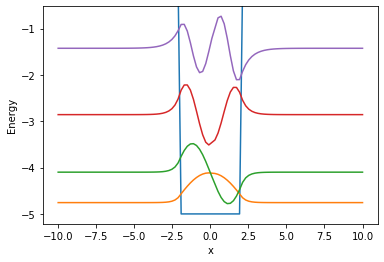

In [12]:
resolution_bis(V=V, E_min=-5, E_max=0, x_m=-10, x_M=10, N_x_c=-1, dx=-1, eps=10**-5, err=10**-3)